# Community alignment of training questions

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## Question sample

In [2]:
from load_forecasted_open_questions import load_forecasted_open_questions

In [3]:
num_questions = (0,100000)

In [4]:
model = 'llama3'

In [5]:
questions = load_forecasted_open_questions(num_questions, model)

2025-06-17 20:45:28.224 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [6]:
len(questions)

859

In [7]:
questions_binary = [question for question in questions if question.api_json['question']['type'] == 'binary']

In [8]:
questions_multiple_choice = [question for question in questions if question.api_json['question']['type'] == 'multiple_choice']

In [9]:
questions_numeric = [question for question in questions if question.api_json['question']['type'] == 'numeric']

In [10]:
[len(x) for x in [questions_binary, questions_multiple_choice, questions_numeric]]

[699, 24, 136]

## Community forecast

In [11]:
from community_forecast import *

In [12]:
id_to_forecast = {question.api_json['id']: community_forecast(question) for question in questions}

In [13]:
id_to_question = {question.api_json['id']: question for question in questions}

## 000 forecast

In [14]:
model = 'llama3'

In [15]:
pdir = f'forecast_{model}'

In [16]:
import glob
fns = glob.glob(f'{pdir}/*.md')

In [17]:
fn = fns[0]

In [18]:
ids = [int(fn.split('/')[1].split('.')[0]) for fn in fns]

In [19]:
len(ids)

863

In [20]:
forecasts = {id: open(f'{pdir}/{id}.md').read() for id in ids}

In [21]:
len(forecasts)

863

In [22]:
community_ids = list(id_to_forecast.keys())

In [23]:
len(community_ids)

859

In [24]:
forecast_ids = list(forecasts.keys())

In [25]:
len(forecast_ids)

863

In [26]:
done = list(set(forecast_ids).intersection(community_ids))

In [27]:
len(done)

711

In [28]:
from extract_forecast import *

def extract_only_forecast(id):
    question = id_to_question[id]
    question_type = type(question)
    forecast = forecasts[id]
    if question_type == forecasting_tools.data_models.questions.BinaryQuestion:
        prediction = extract_probability_from_response_as_percentage_not_decimal(forecast)/100.0
    elif question_type == forecasting_tools.data_models.questions.MultipleChoiceQuestion:
        options = question.options
        option_probabilities = extract_option_probabilities_from_response(forecast, options)
        prediction = generate_multiple_choice_forecast(options, option_probabilities)
    elif question_type == forecasting_tools.data_models.questions.NumericQuestion:
        prediction = extract_percentiles_from_response(forecast)
    return prediction

In [29]:
import forecasting_tools

In [30]:
for id in done:
    try:
        foo = extract_only_forecast(id)
    except:
        print(f'rm forecast_community/{id}.md')

In [31]:
predictions = {id: extract_only_forecast(id) for id in done}

## Put this in a dataframe

In [32]:
from flatten_dict import flatten_dict
import pandas as pd
from prompt_question import prompt_question
pd.set_option('display.max_columns', None)

In [33]:
q_done = [id_to_question[id] for id in done]

In [34]:
qflat = [flatten_dict(q.api_json, sep='_') for q in q_done]

In [35]:
df = pd.DataFrame(qflat)

In [36]:
df['crowd'] = df.apply(lambda row: id_to_forecast[row.id], axis=1)

In [37]:
def pull_asknews(row):
    fn = f'asknews/{row.id}.md'
    with open(fn, 'r') as f:
        return f.read()

In [38]:
df['question_options'] = df['question_options'].apply(repr)

In [39]:
df = df[['id',
 'open_time',
 'scheduled_resolve_time',
 'title',
 'question_description',
 'question_resolution_criteria',
 'question_fine_print',
 'question_type',
 'question_options',
 'question_group_variable',
 'question_question_weight',
 'question_unit',
 'question_open_upper_bound',
 'question_open_lower_bound',
 'question_scaling_range_max',
 'question_scaling_range_min',
 'question_scaling_zero_point',
 'crowd']]

In [55]:
from datetime import datetime
dfn = f'forecast_{model}'
df['today'] = datetime.now().strftime("%Y-%m-%d")

In [56]:
df['asknews'] = df.apply(pull_asknews, axis=1)

In [57]:
df.columns

Index(['id', 'open_time', 'scheduled_resolve_time', 'title',
       'question_description', 'question_resolution_criteria',
       'question_fine_print', 'question_type', 'question_options',
       'question_group_variable', 'question_question_weight', 'question_unit',
       'question_open_upper_bound', 'question_open_lower_bound',
       'question_scaling_range_max', 'question_scaling_range_min',
       'question_scaling_zero_point', 'crowd', 'today', 'asknews', 'research',
       'id_of_question', 'learning', 'prompt'],
      dtype='object')

In [58]:
def load_research(row):
    with open(f"research/{row['id']}.md", 'r') as f:
        return f.read()

df['research'] = df.apply(load_research, axis=1)

In [59]:
df['asknews']

0      Here are the relevant news articles:\n\n**Huma...
1      Here are the relevant news articles:\n\n**Iran...
2      Here are the relevant news articles:\n\n**EU P...
3      Here are the relevant news articles:\n\n**UK D...
4      Here are the relevant news articles:\n\n**US D...
                             ...                        
706    Here are the relevant news articles:\n\n**Bitc...
707    Here are the relevant news articles:\n\n**Bitc...
708    Here are the relevant news articles:\n\n**EU E...
709    Here are the relevant news articles:\n\n**Chat...
710    Here are the relevant news articles:\n\n**Stud...
Name: asknews, Length: 711, dtype: object

In [60]:
from RAGForecaster import RAGForecaster
from EnhancedResearchPro import EnhancedResearchPro

In [61]:
    rag = RAGForecaster()

Loaded existing index from forecast_index.faiss
Index contains 4767 vectors at initialization


In [62]:
    research_bot = EnhancedResearchPro(rag)

In [63]:
df['id_of_question'] = df['id']

In [64]:
    research_bot.process_dataframe(df, use_cutoff=False)

In [65]:
    rag.research_bot = research_bot

    # Updated learning field with raw text extraction
    df['learning'] = df.apply(
        lambda row: [
            m['raw_text'] 
            for m, _ in research_bot.retrieval_cache.get(row['title'], []) 
            if 'raw_text' in m  # Safety check for legacy entries
        ], 
        axis=1
    )


In [66]:
df['prompt'] = df.apply(prompt_question, axis=1)

In [67]:
from tqdm import tqdm
tqdm.pandas()

In [68]:

def predict(dfn, question, iterations = 3):
    ffn = f'{dfn}/{question.id_of_question}.md'
    with open(ffn, 'r') as f:
        return f.read()


In [69]:
df['forecast'] = df.progress_apply(lambda question: predict(dfn, question), axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 711/711 [00:00<00:00, 33762.99it/s]


In [70]:
from extract_forecast import extract_forecast

df['prediction'] = df.apply(extract_forecast, axis=1)

EXTRACT_FORECAST 10243
EXTRACT_FORECAST 10244
EXTRACT_FORECAST 28682
EXTRACT_FORECAST 18444
EXTRACT_FORECAST 16404
EXTRACT_FORECAST 4118
EXTRACT_FORECAST 36887
EXTRACT_FORECAST 4123
EXTRACT_FORECAST 22559
EXTRACT_FORECAST 6179
EXTRACT_FORECAST 20522
EXTRACT_FORECAST 6197
EXTRACT_FORECAST 12348
EXTRACT_FORECAST 18515
EXTRACT_FORECAST 26715
EXTRACT_FORECAST 26717
EXTRACT_FORECAST 26718
EXTRACT_FORECAST 26721
EXTRACT_FORECAST 14441
EXTRACT_FORECAST 20588
EXTRACT_FORECAST 111
EXTRACT_FORECAST 18545
EXTRACT_FORECAST 4215
EXTRACT_FORECAST 10359
EXTRACT_FORECAST 8313
EXTRACT_FORECAST 14456
EXTRACT_FORECAST 4219
EXTRACT_FORECAST 4224
EXTRACT_FORECAST 8324
EXTRACT_FORECAST 8325
EXTRACT_FORECAST 4229
EXTRACT_FORECAST 8327
EXTRACT_FORECAST 8326
EXTRACT_FORECAST 8328
EXTRACT_FORECAST 10393
EXTRACT_FORECAST 6304
EXTRACT_FORECAST 161
EXTRACT_FORECAST 12453
EXTRACT_FORECAST 4264
EXTRACT_FORECAST 16553
EXTRACT_FORECAST 8362
EXTRACT_FORECAST 8363
EXTRACT_FORECAST 10409
EXTRACT_FORECAST 12461
EXTRACT_FO

## Compare

In [71]:
from error import error

In [72]:
df = df[~df.crowd.apply(lambda x: x is None)].copy()

df['error'] = df.apply(error, axis=1)

In [73]:
df.head(3)

,id,open_time,scheduled_resolve_time,title,question_description,question_resolution_criteria,question_fine_print,question_type,question_options,question_group_variable,question_question_weight,question_unit,question_open_upper_bound,question_open_lower_bound,question_scaling_range_max,question_scaling_range_min,question_scaling_zero_point,crowd,today,asknews,research,id_of_question,learning,prompt,forecast,prediction,error
0,10243,2022-03-16T04:00:00Z,3001-01-01T04:59:00Z,"If humanity goes extinct, will another intelli...","In a blog post, Paul Christiano argues that we...","For the purpose of this question, what it mean...",,binary,None,,1.0,,None,None,NaN,NaN,NaN,0.4,2025-06-17,Here are the relevant news articles:\n\n**Huma...,## Key Historical Trends and Current Status\n\...,10243,[],You are a professional forecaster interviewing...,Here is a combined rationale that incorporates...,0.7,0.30
1,10244,2022-08-14T07:00:00Z,2041-01-01T05:00:00Z,Will Iran possess a nuclear weapon before 2041?,A [previous Metaculus question](https://www.me...,This question will resolve as **Yes** if the I...,,binary,None,,1.0,,None,None,NaN,NaN,NaN,0.69,2025-06-17,Here are the relevant news articles:\n\n**Iran...,## 1. Key Historical Trends and Current Status...,10244,[],You are a professional forecaster interviewing...,Here is the combined rationale that incorporat...,0.2,0.49
2,28682,2024-10-01T16:56:00Z,2030-01-01T17:00:00Z,Will any country trigger article 50 to leave t...,This forecasting question is associated with t...,"The question will resolve as **Yes** if, befor...",The completion of the withdrawal process is no...,binary,None,,1.0,,False,False,NaN,NaN,NaN,0.11,2025-06-17,Here are the relevant news articles:\n\n**EU P...,1. **Key Historical Trends and Current Status*...,28682,[],You are a professional forecaster interviewing...,Here is a combined rationale that incorporates...,0.6,0.49


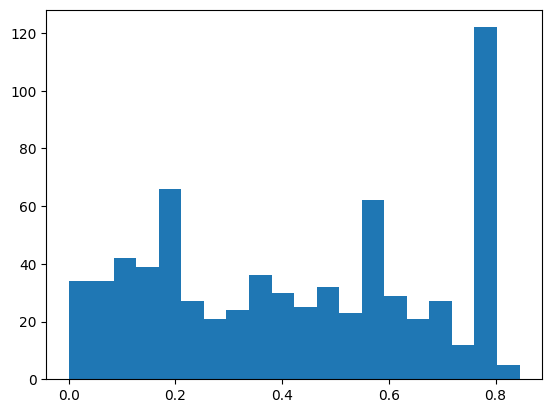

In [74]:
plt.hist(df.error.values, bins=20);

In [77]:
df.to_json(f'community_{model}.json', indent=4)